In [2]:
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
import matplotlib.pyplot as plt
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.options import Options
import re

In [3]:
base_url = "https://nextspaceflight.com/launches/past/"
last_page = 1


In [4]:


options = Options()
options.add_argument("--headless=new")
browser = webdriver.Chrome(options=options)

launch_data = []
for page in range(1, last_page + 1):
    browser.get(f"{base_url}?page={page}")
    cards = browser.find_elements(By.CLASS_NAME, "mdl-card")
    for card in cards:
        company = card.find_element(By.CLASS_NAME, "mdl-card__title-text").text
        rocket_and_payload = card.find_element(By.CLASS_NAME, "header-style").text
        date_and_location = card.find_element(By.CLASS_NAME, "mdl-card__supporting-text").text
        details_url = card.find_element(By.CLASS_NAME, "mdc-button").get_attribute("href")
        border_color = card.value_of_css_property("border-top-color")

        if "rgba(69, 207, 93, 1)" == border_color:
            successful = "1" #Exito
        else:
            successful = "0" #Fracaso

        launch_dict = {
            'company': company,
            'rocket_and_payload': rocket_and_payload,
            'date_and_location': date_and_location,
            'details_url': details_url,
            'successful': successful
        }
        launch_data.append(launch_dict)
browser.quit()

df = pd.DataFrame(launch_data, columns=['company', 'rocket_and_payload', 'date_and_location', 'details_url', 'successful'])

In [5]:
browser = webdriver.Chrome(options=options)
wait = WebDriverWait(browser, 10)


prices = []
leo_weights = []  
gto_weights = []  
rocket_heights = []
fairing_diameters = []
fairing_heights = []

for index in range(len(df.details_url)):
    print(f"Processing launch {index + 1}/{len(df.details_url)}")
    browser.get(df.details_url[index])

    details_els = wait.until(EC.presence_of_all_elements_located((By.CLASS_NAME, "mdl-card__supporting-text")))
    details_texts = [el.text for el in details_els]

    price = 0.0
    leo_weight = 0
    gto_weight = 0
    rocket_h = 0.0
    fairing_d = 0.0
    fairing_h = 0.0

    if len(details_texts) > 1:
        parts = details_texts[1].split("\n")
        for part in parts:
            if "Price: " in part:
                price = part.replace("Price: ", "").replace("$", "").replace(" million", "").strip()
                price = float(price)
            elif "Payload to LEO:" in part:
                leo_weight = part.replace("Payload to LEO:", "").replace("kg", "").strip()
                leo_weight = int(leo_weight.replace(',', ''))
            elif "Payload to GTO:" in part:
                gto_weight = part.replace("Payload to GTO:", "").replace("kg", "").strip()
                gto_weight = int(gto_weight.replace(',', ''))
            elif "Rocket Height:" in part:  
                rocket_h = part.replace("Rocket Height:", "").replace("m", "").strip()
                rocket_h = float(rocket_h)
            elif "Fairing Diameter:" in part:
                fairing_d = part.replace("Fairing Diameter:", "").replace("m", "").strip()
                fairing_d = float(fairing_d)
            elif "Fairing Height:" in part:
                fairing_h = part.replace("Fairing Height:", "").replace("m", "").strip()
                fairing_h = float(fairing_h)

   
    prices.append(price)
    leo_weights.append(leo_weight)
    gto_weights.append(gto_weight)
    rocket_heights.append(rocket_h)
    fairing_diameters.append(fairing_d)
    fairing_heights.append(fairing_h)

browser.quit()


df["price_million"] = prices
df["leo_weight_kg"] = leo_weights
df["gto_weight_kg"] = gto_weights
df["total_payload_kg"] = df["leo_weight_kg"] + df["gto_weight_kg"]
df["rocket_height_m"] = rocket_heights
df["fairing_diameter_m"] = fairing_diameters
df["fairing_height_m"] = fairing_heights

df

Processing launch 1/30
Processing launch 2/30
Processing launch 3/30
Processing launch 4/30
Processing launch 5/30
Processing launch 6/30
Processing launch 7/30
Processing launch 8/30
Processing launch 9/30
Processing launch 10/30
Processing launch 11/30
Processing launch 12/30
Processing launch 13/30
Processing launch 14/30
Processing launch 15/30
Processing launch 16/30
Processing launch 17/30
Processing launch 18/30
Processing launch 19/30
Processing launch 20/30
Processing launch 21/30
Processing launch 22/30
Processing launch 23/30
Processing launch 24/30
Processing launch 25/30
Processing launch 26/30
Processing launch 27/30
Processing launch 28/30
Processing launch 29/30
Processing launch 30/30


,company,rocket_and_payload,date_and_location,details_url,successful,price_million,leo_weight_kg,gto_weight_kg,total_payload_kg,rocket_height_m,fairing_diameter_m,fairing_height_m
0,SpaceX,Falcon 9 Block 5 | Tranche 1 Transport Layer B,"Wed Sep 10, 2025 11:12 CLST\nSLC-4E, Vandenber...",https://nextspaceflight.com/launches/details/7219,1,69.75,22800,8300,31100,70.00,5.20,13.00
1,CASC,Long March 7A | Yaogan 45,"Mon Sep 8, 2025 23:00 CLST\nLC-201, Wenchang S...",https://nextspaceflight.com/launches/details/7943,1,0.00,12000,7000,19000,58.00,4.20,12.40
2,Chinarocket,Jielong 3 | Geely Constellation Group 05,"Mon Sep 8, 2025 16:48 CLST\nOriental Spaceport...",https://nextspaceflight.com/launches/details/7942,1,0.00,1500,0,1500,31.00,3.35,0.00
3,SpaceX,Falcon 9 Block 5 | Starlink Group 17-9,"Sat Sep 6, 2025 2:06 PM CLT\nSLC-4E, Vandenber...",https://nextspaceflight.com/launches/details/7935,1,69.75,22800,8300,31100,70.00,5.20,13.00
4,CASC,Long March 6A | Yaogan 40 Group 03,"Sat Sep 6, 2025 12:34 PM CLT\nLC-9A, Taiyuan S...",https://nextspaceflight.com/launches/details/7940,1,0.00,5000,0,5000,50.00,4.20,5.70
5,SpaceX,Falcon 9 Block 5 | Starlink Group 10-57,"Fri Sep 5, 2025 8:32 AM CLT\nLC-39A, Kennedy S...",https://nextspaceflight.com/launches/details/7934,1,69.75,22800,8300,31100,70.00,5.20,13.00
6,Galactic Energy,Ceres 1 | 3 satellites,"Fri Sep 5, 2025 7:39 AM CLT\nSite 95A, Jiuquan...",https://nextspaceflight.com/launches/details/7939,1,4.38,400,0,400,19.00,1.40,2.50
7,CASC,Long March 3C/YZ-1 | Shiyan 29,"Thu Sep 4, 2025 10:34 PM CLT\nLC-2, Xichang Sa...",https://nextspaceflight.com/launches/details/7938,1,20.00,7500,3500,11000,55.64,4.20,9.78
8,SpaceX,Falcon 9 Block 5 | Starlink Group 10-22,"Wed Sep 3, 2025 7:56 AM CLT\nSLC-40, Cape Cana...",https://nextspaceflight.com/launches/details/7930,1,69.75,22800,8300,31100,70.00,5.20,13.00
9,SpaceX,Falcon 9 Block 5 | Starlink Group 17-8,"Tue Sep 2, 2025 11:51 PM CLT\nSLC-4E, Vandenbe...",https://nextspaceflight.com/launches/details/7931,1,69.75,22800,8300,31100,70.00,5.20,13.00


In [6]:
df.size
df.shape

(30, 12)

In [7]:
df.to_csv('launches.csv', index=False)

In [8]:
df["rocket"] = df["rocket_and_payload"].str.split("|").str[0]
df["payload"] = df["rocket_and_payload"].str.split("|").str[1]
df["date"] = df["date_and_location"].str.split("\n").str[0]
df["location"] = df["date_and_location"].str.split("\n").str[1]
df.drop(columns=["rocket_and_payload", "date_and_location"], inplace=True)
df

,company,details_url,successful,price_million,leo_weight_kg,gto_weight_kg,total_payload_kg,rocket_height_m,fairing_diameter_m,fairing_height_m,rocket,payload,date,location
0,SpaceX,https://nextspaceflight.com/launches/details/7219,1,69.75,22800,8300,31100,70.00,5.20,13.00,Falcon 9 Block 5,Tranche 1 Transport Layer B,"Wed Sep 10, 2025 11:12 CLST","SLC-4E, Vandenberg SFB, California, USA"
1,CASC,https://nextspaceflight.com/launches/details/7943,1,0.00,12000,7000,19000,58.00,4.20,12.40,Long March 7A,Yaogan 45,"Mon Sep 8, 2025 23:00 CLST","LC-201, Wenchang Space Launch Site, China"
2,Chinarocket,https://nextspaceflight.com/launches/details/7942,1,0.00,1500,0,1500,31.00,3.35,0.00,Jielong 3,Geely Constellation Group 05,"Mon Sep 8, 2025 16:48 CLST","Oriental Spaceport Launch Ship (Area 1), China..."
3,SpaceX,https://nextspaceflight.com/launches/details/7935,1,69.75,22800,8300,31100,70.00,5.20,13.00,Falcon 9 Block 5,Starlink Group 17-9,"Sat Sep 6, 2025 2:06 PM CLT","SLC-4E, Vandenberg SFB, California, USA"
4,CASC,https://nextspaceflight.com/launches/details/7940,1,0.00,5000,0,5000,50.00,4.20,5.70,Long March 6A,Yaogan 40 Group 03,"Sat Sep 6, 2025 12:34 PM CLT","LC-9A, Taiyuan Satellite Launch Center, China"
5,SpaceX,https://nextspaceflight.com/launches/details/7934,1,69.75,22800,8300,31100,70.00,5.20,13.00,Falcon 9 Block 5,Starlink Group 10-57,"Fri Sep 5, 2025 8:32 AM CLT","LC-39A, Kennedy Space Center, Florida, USA"
6,Galactic Energy,https://nextspaceflight.com/launches/details/7939,1,4.38,400,0,400,19.00,1.40,2.50,Ceres 1,3 satellites,"Fri Sep 5, 2025 7:39 AM CLT","Site 95A, Jiuquan Satellite Launch Center, China"
7,CASC,https://nextspaceflight.com/launches/details/7938,1,20.00,7500,3500,11000,55.64,4.20,9.78,Long March 3C/YZ-1,Shiyan 29,"Thu Sep 4, 2025 10:34 PM CLT","LC-2, Xichang Satellite Launch Center, China"
8,SpaceX,https://nextspaceflight.com/launches/details/7930,1,69.75,22800,8300,31100,70.00,5.20,13.00,Falcon 9 Block 5,Starlink Group 10-22,"Wed Sep 3, 2025 7:56 AM CLT","SLC-40, Cape Canaveral SFS, Florida, USA"
9,SpaceX,https://nextspaceflight.com/launches/details/7931,1,69.75,22800,8300,31100,70.00,5.20,13.00,Falcon 9 Block 5,Starlink Group 17-8,"Tue Sep 2, 2025 11:51 PM CLT","SLC-4E, Vandenberg SFB, California, USA"


In [9]:
def clean_date(scraped_date_string):
    months = {"Jan":"01", "Feb":"02", "Mar":"03", "Apr":"04", "May":"05", "Jun":"06",
              "Jul":"07", "Aug":"08", "Sep":"09", "Oct":"10", "Nov":"11", "Dec":"12"}
    parts = scraped_date_string.split(" ")
    month = parts[1]
    day = parts[2].replace(",", "")
    year = parts[3]
    return f"{year}/{months[month]}/{day}"

In [10]:
df["cleaned_date"] = df["date"].apply(clean_date)
df["year"] = df["cleaned_date"].str.split("/").str[0]
df["month"] = df["cleaned_date"].str.split("/").str[1]
df["day"] = df["cleaned_date"].str.split("/").str[2]
df.drop(columns=["date", "cleaned_date"], inplace=True)
df

,company,details_url,successful,price_million,leo_weight_kg,gto_weight_kg,total_payload_kg,rocket_height_m,fairing_diameter_m,fairing_height_m,rocket,payload,location,year,month,day
0,SpaceX,https://nextspaceflight.com/launches/details/7219,1,69.75,22800,8300,31100,70.00,5.20,13.00,Falcon 9 Block 5,Tranche 1 Transport Layer B,"SLC-4E, Vandenberg SFB, California, USA",2025,09,10
1,CASC,https://nextspaceflight.com/launches/details/7943,1,0.00,12000,7000,19000,58.00,4.20,12.40,Long March 7A,Yaogan 45,"LC-201, Wenchang Space Launch Site, China",2025,09,8
2,Chinarocket,https://nextspaceflight.com/launches/details/7942,1,0.00,1500,0,1500,31.00,3.35,0.00,Jielong 3,Geely Constellation Group 05,"Oriental Spaceport Launch Ship (Area 1), China...",2025,09,8
3,SpaceX,https://nextspaceflight.com/launches/details/7935,1,69.75,22800,8300,31100,70.00,5.20,13.00,Falcon 9 Block 5,Starlink Group 17-9,"SLC-4E, Vandenberg SFB, California, USA",2025,09,6
4,CASC,https://nextspaceflight.com/launches/details/7940,1,0.00,5000,0,5000,50.00,4.20,5.70,Long March 6A,Yaogan 40 Group 03,"LC-9A, Taiyuan Satellite Launch Center, China",2025,09,6
5,SpaceX,https://nextspaceflight.com/launches/details/7934,1,69.75,22800,8300,31100,70.00,5.20,13.00,Falcon 9 Block 5,Starlink Group 10-57,"LC-39A, Kennedy Space Center, Florida, USA",2025,09,5
6,Galactic Energy,https://nextspaceflight.com/launches/details/7939,1,4.38,400,0,400,19.00,1.40,2.50,Ceres 1,3 satellites,"Site 95A, Jiuquan Satellite Launch Center, China",2025,09,5
7,CASC,https://nextspaceflight.com/launches/details/7938,1,20.00,7500,3500,11000,55.64,4.20,9.78,Long March 3C/YZ-1,Shiyan 29,"LC-2, Xichang Satellite Launch Center, China",2025,09,4
8,SpaceX,https://nextspaceflight.com/launches/details/7930,1,69.75,22800,8300,31100,70.00,5.20,13.00,Falcon 9 Block 5,Starlink Group 10-22,"SLC-40, Cape Canaveral SFS, Florida, USA",2025,09,3
9,SpaceX,https://nextspaceflight.com/launches/details/7931,1,69.75,22800,8300,31100,70.00,5.20,13.00,Falcon 9 Block 5,Starlink Group 17-8,"SLC-4E, Vandenberg SFB, California, USA",2025,09,2


In [11]:
volumen_cohete = 3.1416 * (df["fairing_diameter_m"] / 2) ** 2 * df["rocket_height_m"]
volumen_carenado = 3.1416 * (df["fairing_diameter_m"] / 2) ** 2 * df["fairing_height_m"] * (1/3)
df["volumen_total_m3"] = volumen_cohete + volumen_carenado
df


,company,details_url,successful,price_million,leo_weight_kg,gto_weight_kg,total_payload_kg,rocket_height_m,fairing_diameter_m,fairing_height_m,rocket,payload,location,year,month,day,volumen_total_m3
0,SpaceX,https://nextspaceflight.com/launches/details/7219,1,69.75,22800,8300,31100,70.00,5.20,13.00,Falcon 9 Block 5,Tranche 1 Transport Layer B,"SLC-4E, Vandenberg SFB, California, USA",2025,09,10,1578.633056
1,CASC,https://nextspaceflight.com/launches/details/7943,1,0.00,12000,7000,19000,58.00,4.20,12.40,Long March 7A,Yaogan 45,"LC-201, Wenchang Space Launch Site, China",2025,09,8,860.823533
2,Chinarocket,https://nextspaceflight.com/launches/details/7942,1,0.00,1500,0,1500,31.00,3.35,0.00,Jielong 3,Geely Constellation Group 05,"Oriental Spaceport Launch Ship (Area 1), China...",2025,09,8,273.238697
3,SpaceX,https://nextspaceflight.com/launches/details/7935,1,69.75,22800,8300,31100,70.00,5.20,13.00,Falcon 9 Block 5,Starlink Group 17-9,"SLC-4E, Vandenberg SFB, California, USA",2025,09,6,1578.633056
4,CASC,https://nextspaceflight.com/launches/details/7940,1,0.00,5000,0,5000,50.00,4.20,5.70,Long March 6A,Yaogan 40 Group 03,"LC-9A, Taiyuan Satellite Launch Center, China",2025,09,6,719.046266
5,SpaceX,https://nextspaceflight.com/launches/details/7934,1,69.75,22800,8300,31100,70.00,5.20,13.00,Falcon 9 Block 5,Starlink Group 10-57,"LC-39A, Kennedy Space Center, Florida, USA",2025,09,5,1578.633056
6,Galactic Energy,https://nextspaceflight.com/launches/details/7939,1,4.38,400,0,400,19.00,1.40,2.50,Ceres 1,3 satellites,"Site 95A, Jiuquan Satellite Launch Center, China",2025,09,5,30.531116
7,CASC,https://nextspaceflight.com/launches/details/7938,1,20.00,7500,3500,11000,55.64,4.20,9.78,Long March 3C/YZ-1,Shiyan 29,"LC-2, Xichang Satellite Launch Center, China",2025,09,4,816.027458
8,SpaceX,https://nextspaceflight.com/launches/details/7930,1,69.75,22800,8300,31100,70.00,5.20,13.00,Falcon 9 Block 5,Starlink Group 10-22,"SLC-40, Cape Canaveral SFS, Florida, USA",2025,09,3,1578.633056
9,SpaceX,https://nextspaceflight.com/launches/details/7931,1,69.75,22800,8300,31100,70.00,5.20,13.00,Falcon 9 Block 5,Starlink Group 17-8,"SLC-4E, Vandenberg SFB, California, USA",2025,09,2,1578.633056


### Visualización de datos

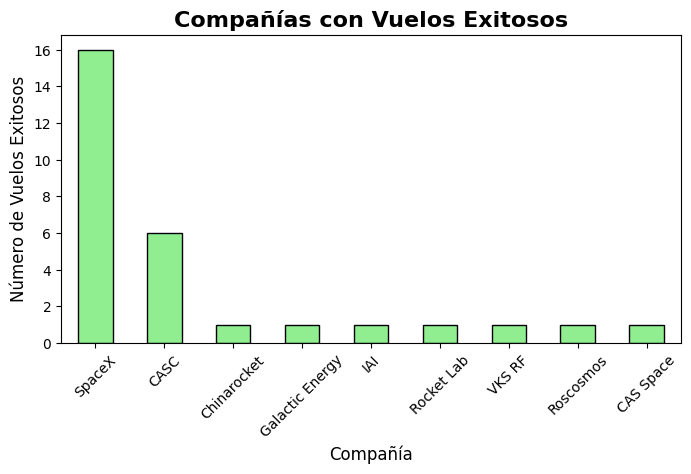


Vuelos exitosos por compañia:
company
SpaceX             16
CASC                6
Chinarocket         1
Galactic Energy     1
IAI                 1
Rocket Lab          1
VKS RF              1
Roscosmos           1
CAS Space           1
Name: count, dtype: int64


In [12]:
df_exitosos = df[df['successful'] == '1']

vuelos_exitosos_por_compania = df_exitosos['company'].value_counts()

plt.figure(figsize=(8, 4))
ax = vuelos_exitosos_por_compania.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title('Compañías con Vuelos Exitosos', fontsize=16, fontweight='bold')
plt.xlabel('Compañía', fontsize=12)
plt.ylabel('Número de Vuelos Exitosos', fontsize=12)
plt.xticks(rotation=45)
plt.show()

print("\nVuelos exitosos por compañia:")
print(vuelos_exitosos_por_compania)

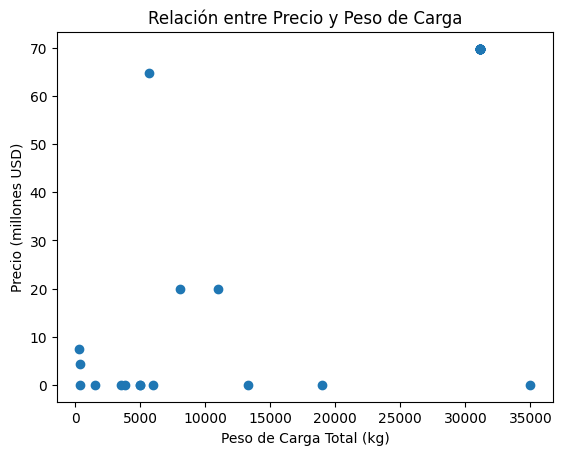

    price_million  total_payload_kg
0           69.75             31100
1            0.00             19000
2            0.00              1500
3           69.75             31100
4            0.00              5000
5           69.75             31100
6            4.38               400
7           20.00             11000
8           69.75             31100
9           69.75             31100
10           0.00               350
11          69.75             31100
12          69.75             31100
13          69.75             31100
14          69.75             31100
15           0.00             35000
16          69.75             31100
17           0.00             13300
18          69.75             31100
19           7.50               320
20          69.75             31100
21          69.75             31100
22           0.00              3800
23          20.00              8020
24           0.00              3500
25          69.75             31100
26           0.00           

In [16]:
df_valor_carga = df[['price_million', 'total_payload_kg']]

plt.scatter(df['total_payload_kg'], df['price_million'])
plt.title('Relación entre Precio y Peso de Carga')
plt.xlabel('Peso de Carga Total (kg)')
plt.ylabel('Precio (millones USD)')
plt.show()

print(df_valor_carga)